## Market basket analysis - Jason Chandra

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# Garbage Collector to free up memory
import gc
gc.enable()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
root = '/content/drive/Shareddrives/Data Mining Project/Data/'
os.listdir(root)

['aisles.csv',
 'departments.csv',
 'order_products__train.csv',
 'order_products__prior.csv',
 'orders.csv',
 'products.csv',
 'final_merged_dataset_chandra.csv']

In [9]:
#setting all dataframes
aisles = pd.read_csv(root + 'aisles.csv')
departments = pd.read_csv(root + 'departments.csv')
orders = pd.read_csv(root + 'orders.csv')
order_products_prior = pd.read_csv(root + 'order_products__prior.csv')
order_products_train = pd.read_csv(root + 'order_products__train.csv')
products = pd.read_csv(root + 'products.csv')

**Exploring the dataset AISLES**

In [5]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
aisles.shape

(134, 2)

Ok, interesting. 134 different aisles. this is ok, we can use this for cluster comparison. So like a before and after. Once we have new clusters that can be compared vs now.

**Departments**

In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
departments.shape

(21, 2)

**ORDERS**

In [9]:
orders.head()



,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [11]:
len(orders.order_id.unique())


3421083

In [12]:
len(orders.user_id.unique())

206209


- Order ID: Distinct identifier for each order.
- User ID: Distinct identifier for each user.
- Evaluation Set: Indicates whether the data is for prior, train, or test.
- Order Number: The sequence number of the order by the user.
- Order Day of Week: Specifies the day of the week the order was placed.
- Order Time of Day: Specifies the hour of the day the order was made.
- Days Since Last Order: The number of days between consecutive orders.


2 / 2






**order_products__train**

In [13]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1



- Order ID: A unique identifier for each order.
- Product ID: Identifier for the product.
- Cart Sequence: Represents the order in which items were added to the cart.
- Reorder Status: Indicates whether a product has been reordered (1 for yes, 0 for no).

**order_products_prior**

In [14]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Same as train.

### 1.1 Recap of all of the types

We can split all of the data into 3 clear types:

- Historical Data: Records the order history for each user.
- Training Data: Contains the latest order information for each user, limited to one order per user.
- **Testing Data**: Represents the anticipated future orders of each user, lacking any product details (which are to be predicted).

### 1.2 UNIFIED Dataset - Merging all of the important ones together

In [15]:
# Merging Datasets to Create a Unified Dataset

# Combine prior and train orders
combined_orders = pd.concat([order_products_prior, order_products_train]).sort_values(by='order_id')

# Merge combined orders with products, aisles, and departments
merged_data = combined_orders.merge(products, on='product_id').merge(aisles, on='aisle_id').merge(departments, on='department_id')



In [ ]:
# Integrate the merged data with the orders dataset
final_dataset = merged_data.merge(orders, on='order_id').sort_values(by='order_id').reset_index(drop=True)

# Define the column order for the final dataset
columns_order = ['user_id', 'order_id', 'product_id', 'aisle_id', 'department_id', 'add_to_cart_order', 'reordered', 'product_name', 'aisle', 'department', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

# Reorder the final dataset according to the specified column order
final_dataset = final_dataset[columns_order]



In [2]:
### IMPORT TEMP
##final_dataset = pd.read_csv('final_merged_dataset_chandra.csv')



In [3]:
# Final dataset ready for analysis
final_dataset.head()

,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,112108,1,49302,120,16,1,1,Bulgarian Yogurt,yogurt,dairy eggs,train,4,4,10,9.0
1,112108,1,10246,83,4,3,0,Organic Celery Hearts,fresh vegetables,produce,train,4,4,10,9.0
2,112108,1,49683,83,4,4,0,Cucumber Kirby,fresh vegetables,produce,train,4,4,10,9.0
3,112108,1,43633,95,15,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,train,4,4,10,9.0
4,112108,1,13176,24,4,6,0,Bag of Organic Bananas,fresh fruits,produce,train,4,4,10,9.0


In [4]:
final_dataset.shape

(33819106, 15)

### 1.3 - Missing Data, Imputation, etc.

In [5]:
# Calculate the percentage of missing values for each column
missing_percentage = final_dataset.isnull().mean() * 100

missing_percentage

user_id                   0.000000
order_id                  0.000000
product_id                0.000000
aisle_id                  0.000000
department_id             0.000000
add_to_cart_order         0.000000
reordered                 0.000000
product_name              0.000000
aisle                     0.000000
department                0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.144657
dtype: float64

The only missing data is in the orders.csv section. 

If all the other data is clean, there is one possible answer - and that is, all of the NaN values is 0 because it is the first order of users. And, 6% is also a large number.

In [6]:
# Check if all NaN values in 'days_since_prior_order' correspond to the first order of users (order_number = 1)
nan_first_order = final_dataset[final_dataset['days_since_prior_order'].isnull()]['order_number'].eq(1).all()

# Check the result
nan_first_order


True

**Imputing** to 0, due to the description above.

After imputing missing values in the days_since_prior_order column with 0 for orders where order_number equals 1, the percentage of missing values in this column dropped to 0%. This aligns with the approach of setting the days_since_prior_order to 0 for a user's first order, under the assumption that there's no prior order.

In [8]:
# Impute NaN values in 'days_since_prior_order' with 0

final_dataset['days_since_prior_order'].fillna(0, inplace=True)

# Verify the imputation by calculating the percentage of missing values again
missing_percentage_after_imputation = final_dataset.isnull().mean() * 100

missing_percentage_after_imputation


/var/folders/06/4lfc08752zv_l79gm6nmv18w0000gn/T/ipykernel_96325/4269487997.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataset['days_since_prior_order'].fillna(0, inplace=True)


user_id                   0.0
order_id                  0.0
product_id                0.0
aisle_id                  0.0
department_id             0.0
add_to_cart_order         0.0
reordered                 0.0
product_name              0.0
aisle                     0.0
department                0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
dtype: float64

In [9]:
# Save the same DataFrame to a parquet file
final_dataset.to_parquet('final_complete_dataset.parquet', index=False)

### 2. Exploratory Data Analysis

### 2.1 - Ratio of reordered products

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


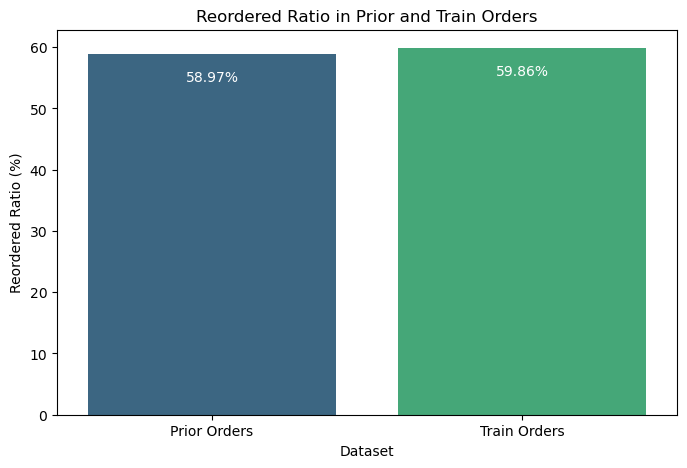

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


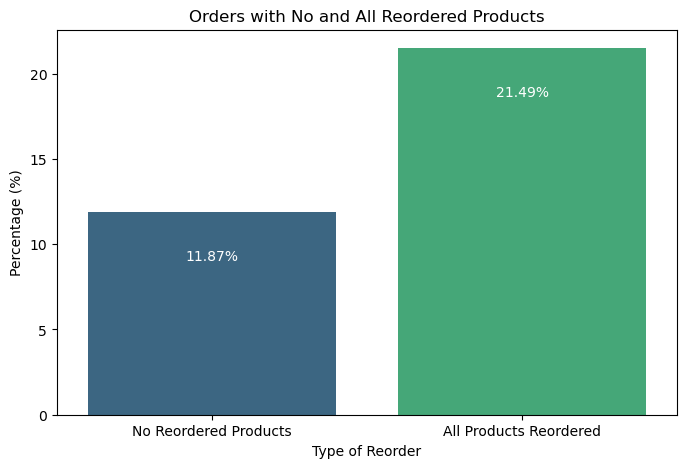

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the reorder ratio for each eval_set
reorder_ratio_prior = final_dataset[final_dataset['eval_set'] == 'prior']['reordered'].mean() * 100
reorder_ratio_train = final_dataset[final_dataset['eval_set'] == 'train']['reordered'].mean() * 100

# Prepare data for plotting
reorder_ratios = [reorder_ratio_prior, reorder_ratio_train]
eval_sets = ['Prior Orders', 'Train Orders']

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x=eval_sets, y=reorder_ratios, palette="viridis")
plt.title('Reordered Ratio in Prior and Train Orders')
plt.ylabel('Reordered Ratio (%)')
plt.xlabel('Dataset')
for index, value in enumerate(reorder_ratios):
    plt.text(index, value - 5, f'{value:.2f}%', ha='center', va='bottom', color='white')
plt.show()

# Analysis of orders with no reordered products and all products reordered
# Group by order_id to get reorder statistics per order
grouped_df = final_dataset.groupby('order_id').agg({'reordered':'mean'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
grouped_df['no_reordered'] = (grouped_df['reordered_ratio'] == 0).astype(int)
grouped_df['all_reordered'] = (grouped_df['reordered_ratio'] == 1.0).astype(int)

# Calculate percentages for orders with no reorders and all reorders
no_reorder_percentage = grouped_df['no_reordered'].mean() * 100
all_reorder_percentage = grouped_df['all_reordered'].mean() * 100

# Prepare data for plotting
reorder_stats = [no_reorder_percentage, all_reorder_percentage]
reorder_types = ['No Reordered Products', 'All Products Reordered']

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x=reorder_types, y=reorder_stats, palette="viridis")
plt.title('Orders with No and All Reordered Products')
plt.ylabel('Percentage (%)')
plt.xlabel('Type of Reorder')
for index, value in enumerate(reorder_stats):
    plt.text(index, value - 3, f'{value:.2f}%', ha='center', va='bottom', color='white')
plt.show()

- Reordered Product Trends: Both prior and train orders show that over half of the products are reordered, with train orders having a slightly higher reorder rate. This suggests that a considerable portion of customer purchases are repeat orders, which could indicate customer loyalty or satisfaction with those products. 

- No Reorder vs. Full Reorder Orders: The data also shows a stark contrast between orders with no reordered products and those with all products reordered. While only a small percentage (11.87%) of orders contain exclusively first-time purchases, a significant portion (21.49%) of orders consist entirely of products that have been ordered before. This might reflect two distinct shopping behaviors: one segment of customers is inclined to explore new products, while another prefers to stick with what they know.

### 2.2 - Basket very high level overview

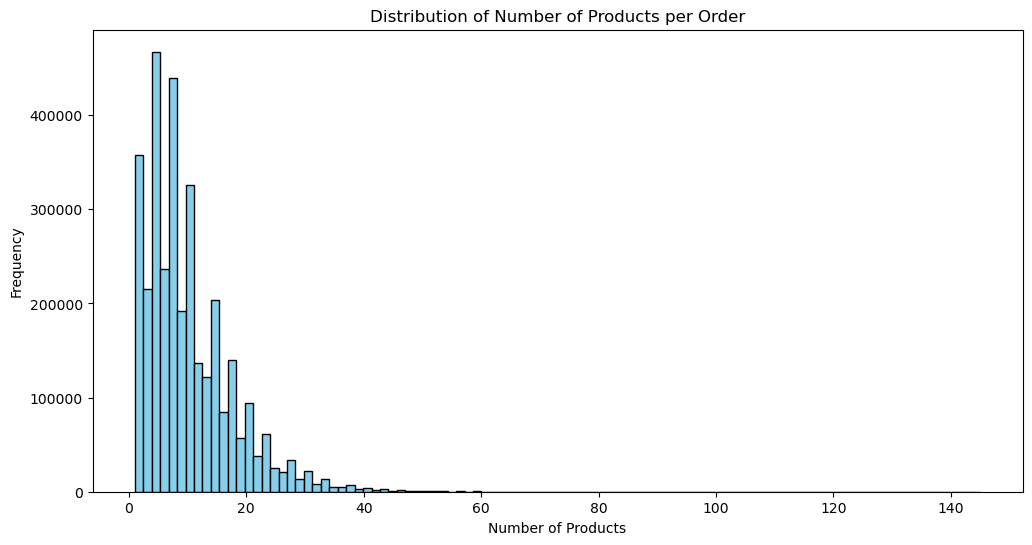

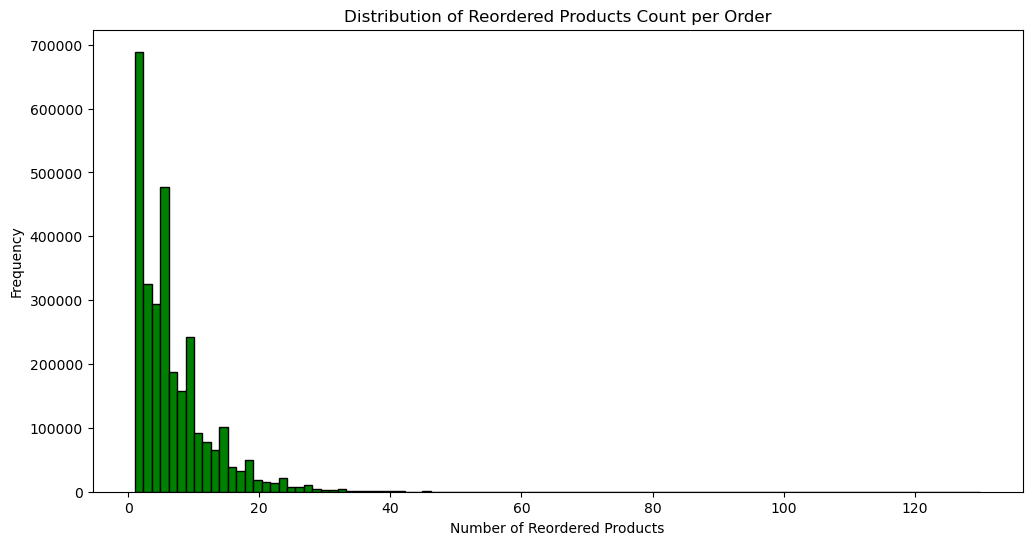

In [15]:
import matplotlib.pyplot as plt

# Calculate the total number of products in each order
products_per_order = final_dataset.groupby('order_id')['product_id'].count()


# Plotting the histogram for the number of products in an order
plt.figure(figsize=(12, 6))
products_per_order.hist(bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Products per Order')
plt.xlabel('Number of Products')
plt.ylabel('Frequency')
plt.grid(False)  # Turn off the grid to make the plot cleaner
plt.show()

# Now, let's analyze the count of reordered products in a basket (order)
reordered_products_per_order = final_dataset[final_dataset['reordered'] == 1].groupby('order_id')['product_id'].count()

# Plotting the histogram for the count of reordered products per order
plt.figure(figsize=(12, 6))
reordered_products_per_order.hist(bins=100, color='green', edgecolor='black')
plt.title('Distribution of Reordered Products Count per Order')
plt.xlabel('Number of Reordered Products')
plt.ylabel('Frequency')
plt.grid(False)  # Turn off the grid to make the plot cleaner
plt.show()


In [16]:

# Summary statistics for the total number of products per order
total_products_stats = products_per_order.describe()

total_products_stats

count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64

In [17]:
# Summary statistics for the total number of reordered products per order
reordered_products_stats = reordered_products_per_order.describe()

reordered_products_stats

count    2.948968e+06
mean     6.766896e+00
std      5.775252e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      9.000000e+00
max      1.300000e+02
Name: product_id, dtype: float64

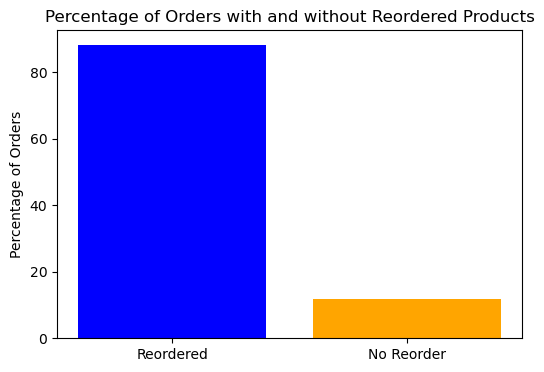

In [20]:
# To calculate the percentage of orders with no reordered products, we'll divide the number of orders with no reorders by the total number of orders.

# Total number of orders
total_orders = final_dataset['order_id'].nunique()

# Calculate the percentage
orders_no_reorder_percentage = (orders_no_reorder_count / total_orders) * 100

# Plot for percentage of orders with no reordered products
plt.figure(figsize=(6,4))
plt.bar(['Reordered', 'No Reorder'], [100 - orders_no_reorder_percentage, orders_no_reorder_percentage], color=['blue', 'orange'])
plt.title('Percentage of Orders with and without Reordered Products')
plt.ylabel('Percentage of Orders')
plt.show()


### 2.3 - Most popular/reordered on an overall level, aisle, department, etc.

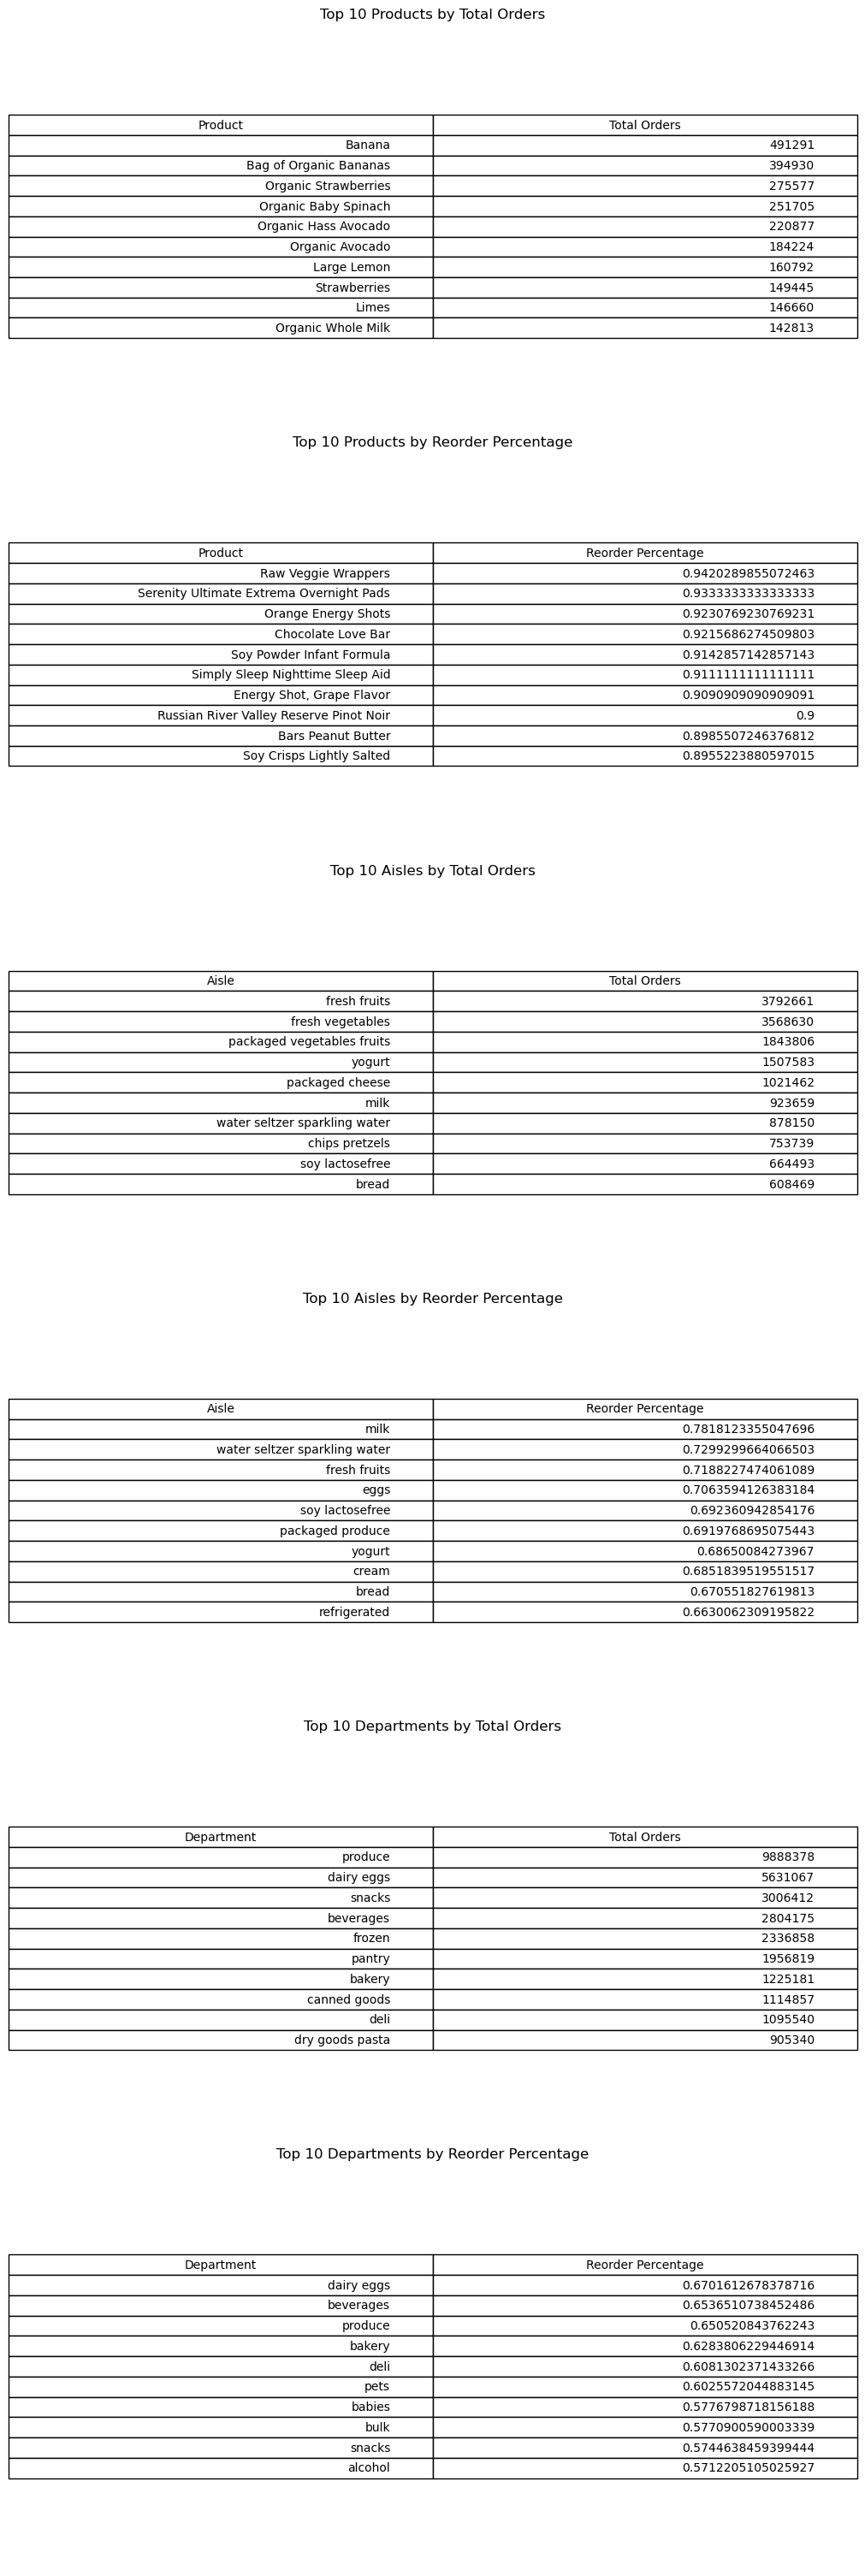

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# For the revised task, we need to generate six tables in total:
# - Top 10 Products by Total Orders
# - Top 10 Products by Reorder Percentage
# - Top 10 Aisles by Total Orders
# - Top 10 Aisles by Reorder Percentage
# - Top 10 Departments by Total Orders
# - Top 10 Departments by Reorder Percentage

# Top 10 Products by Total Orders
product_total_orders = final_dataset['product_name'].value_counts().head(10)

# Top 10 Products by Reorder Percentage
product_reorder_percentage = (final_dataset[final_dataset['reordered'] == 1]['product_name'].value_counts() / final_dataset['product_name'].value_counts()).sort_values(ascending=False).head(10)

# Top 10 Aisles by Total Orders
aisle_total_orders = final_dataset.groupby('aisle')['product_id'].count().sort_values(ascending=False).head(10)

# Top 10 Aisles by Reorder Percentage
aisle_reorder_percentage = (final_dataset[final_dataset['reordered'] == 1].groupby('aisle')['product_id'].count() / final_dataset.groupby('aisle')['product_id'].count()).sort_values(ascending=False).head(10)

# Top 10 Departments by Total Orders
department_total_orders = final_dataset.groupby('department')['product_id'].count().sort_values(ascending=False).head(10)

# Top 10 Departments by Reorder Percentage
department_reorder_percentage = (final_dataset[final_dataset['reordered'] == 1].groupby('department')['product_id'].count() / final_dataset.groupby('department')['product_id'].count()).sort_values(ascending=False).head(10)

# Plotting the tables
fig, axes = plt.subplots(6, 1, figsize=(10, 30), constrained_layout=True)

# Top 10 Products by Total Orders
axes[0].axis('off')
axes[0].table(cellText=product_total_orders.reset_index().values, colLabels=['Product', 'Total Orders'], loc='center')
axes[0].set_title('Top 10 Products by Total Orders')

# Top 10 Products by Reorder Percentage
axes[1].axis('off')
axes[1].table(cellText=product_reorder_percentage.reset_index().values, colLabels=['Product', 'Reorder Percentage'], loc='center')
axes[1].set_title('Top 10 Products by Reorder Percentage')

# Top 10 Aisles by Total Orders
axes[2].axis('off')
axes[2].table(cellText=aisle_total_orders.reset_index().values, colLabels=['Aisle', 'Total Orders'], loc='center')
axes[2].set_title('Top 10 Aisles by Total Orders')

# Top 10 Aisles by Reorder Percentage
axes[3].axis('off')
axes[3].table(cellText=aisle_reorder_percentage.reset_index().values, colLabels=['Aisle', 'Reorder Percentage'], loc='center')
axes[3].set_title('Top 10 Aisles by Reorder Percentage')

# Top 10 Departments by Total Orders
axes[4].axis('off')
axes[4].table(cellText=department_total_orders.reset_index().values, colLabels=['Department', 'Total Orders'], loc='center')
axes[4].set_title('Top 10 Departments by Total Orders')

# Top 10 Departments by Reorder Percentage
axes[5].axis('off')
axes[5].table(cellText=department_reorder_percentage.reset_index().values, colLabels=['Department', 'Reorder Percentage'], loc='center')
axes[5].set_title('Top 10 Departments by Reorder Percentage')

plt.show()


### 2.4 - Effect of Time 

#### 2.4.1 - Impact of Day of Week and Hour of Day on Product Orders/Reorders

/var/folders/06/4lfc08752zv_l79gm6nmv18w0000gn/T/ipykernel_96325/3174535509.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([bar1, bar2], labels=['All Orders', 'Reorders'])


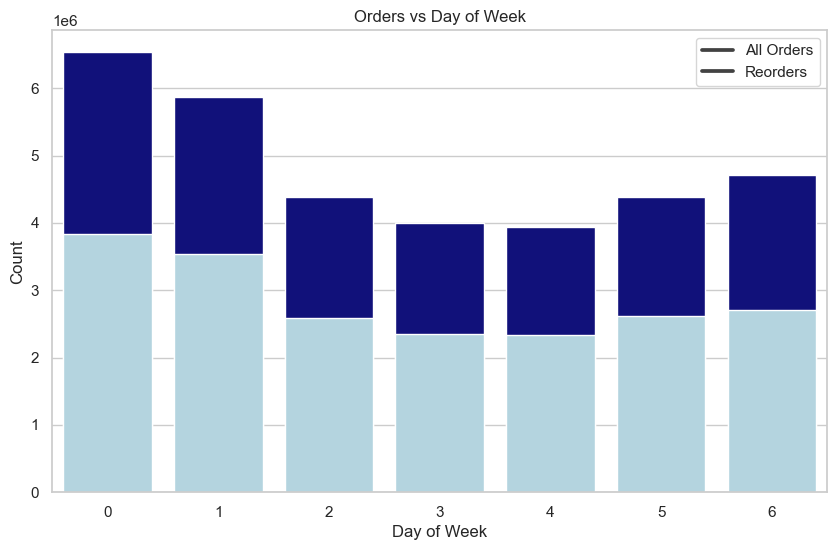

/var/folders/06/4lfc08752zv_l79gm6nmv18w0000gn/T/ipykernel_96325/3174535509.py:39: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([bar1, bar2], labels=['All Orders', 'Reorders'])


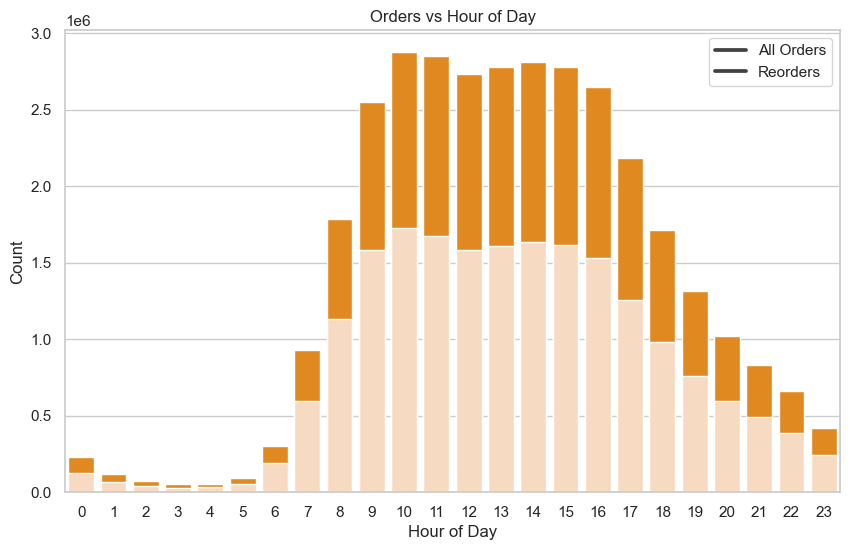

In [29]:
# Group by 'order_dow' and count the number of orders and reorders.
orders_by_dow = final_dataset.groupby('order_dow').size().reset_index(name='total_orders')
reorders_by_dow = final_dataset[final_dataset['reordered'] == 1].groupby('order_dow').size().reset_index(name='reorders')

# Merge the two dataframes on 'order_dow' to combine the data.
dow = pd.merge(orders_by_dow, reorders_by_dow, on='order_dow', how='left').fillna(0)

# Plot the data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar1 = sns.barplot(x="order_dow",  y="total_orders", data=dow, color='darkblue')
bar2 = sns.barplot(x="order_dow", y="reorders", data=dow, color='lightblue')

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Orders vs Day of Week')
plt.legend([bar1, bar2], labels=['All Orders', 'Reorders'])
plt.show()

# Next, we will plot the orders by hour of day.

# Group by 'order_hour_of_day' and count the number of orders and reorders.
orders_by_hour = final_dataset.groupby('order_hour_of_day').size().reset_index(name='total_orders')
reorders_by_hour = final_dataset[final_dataset['reordered'] == 1].groupby('order_hour_of_day').size().reset_index(name='reorders')

# Merge the two dataframes on 'order_hour_of_day' to combine the data.
hour = pd.merge(orders_by_hour, reorders_by_hour, on='order_hour_of_day', how='left').fillna(0)

# Plot the data
plt.figure(figsize=(10, 6))
bar1 = sns.barplot(x="order_hour_of_day",  y="total_orders", data=hour, color='darkorange')
bar2 = sns.barplot(x="order_hour_of_day", y="reorders", data=hour, color='peachpuff')

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Orders vs Hour of Day')
plt.legend([bar1, bar2], labels=['All Orders', 'Reorders'])
plt.show()

#### 2.4.2 - Distribution of Days Since Prior Order for Orders and Reorders: To understand user habits in terms of how frequently they order or reorder, we can plot a histogram.

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chandrajason/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/chandrajason/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/chandrajason/anaconda3/lib/python3.11/site-packages/s

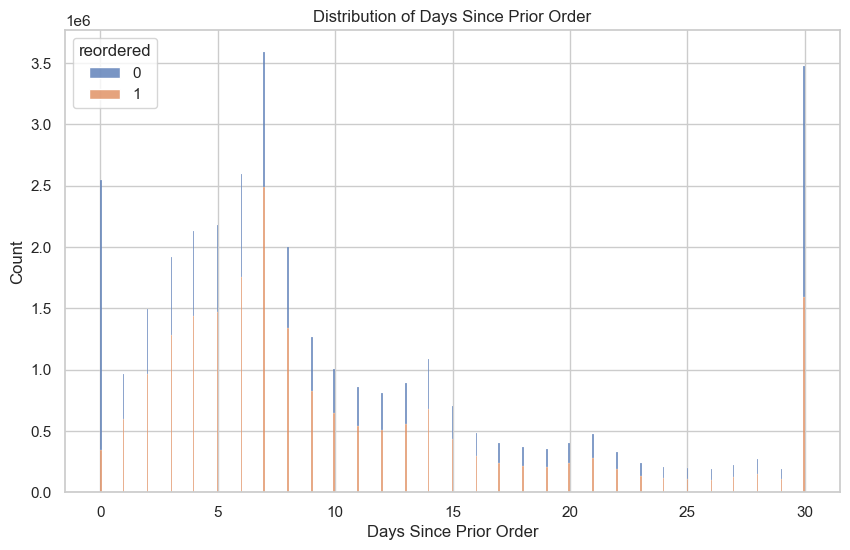

In [30]:
# Question 1: Distribution of Days Since Prior Order for Orders and Reorders
plt.figure(figsize=(10, 6))
sns.histplot(data=final_dataset, x='days_since_prior_order', hue='reordered', multiple='stack')
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count')
plt.show()

A lot of weekly, a lot of upper limit.... good insights.

#### 2.4.3 - Top Products Purchased by Weekly and Monthly Buyers: Identifying products that are frequently bought by users who purchase weekly and monthly can be insightful. We can create bar plots for this.



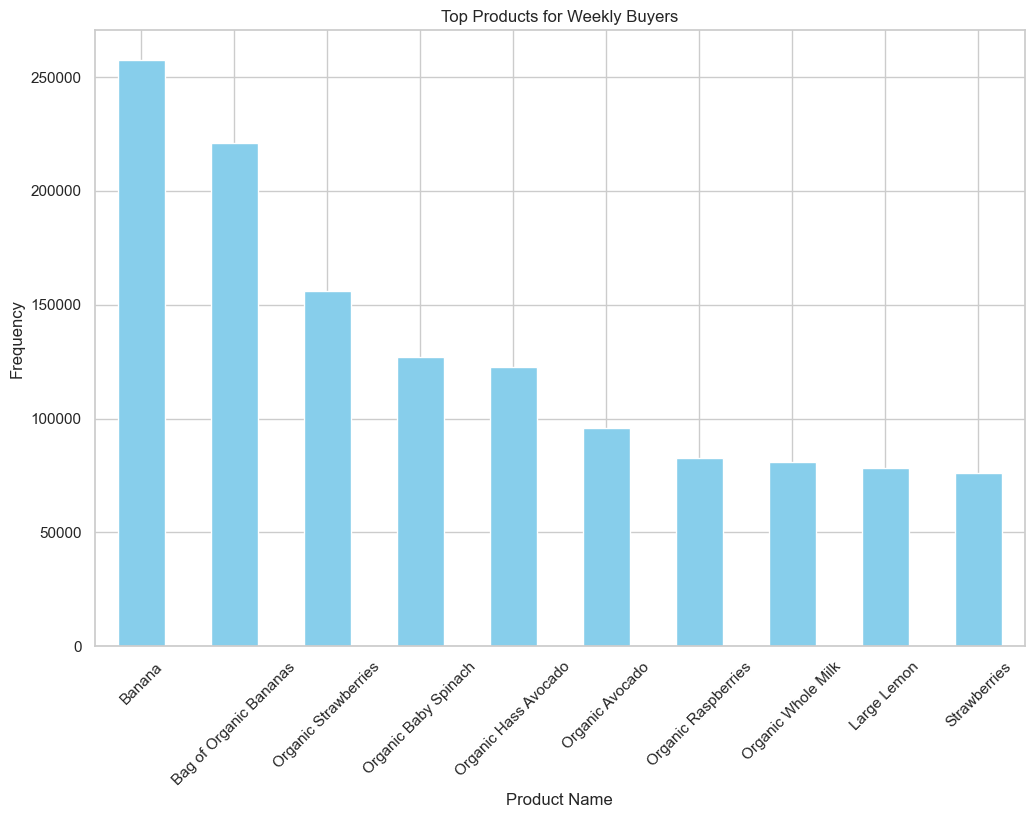

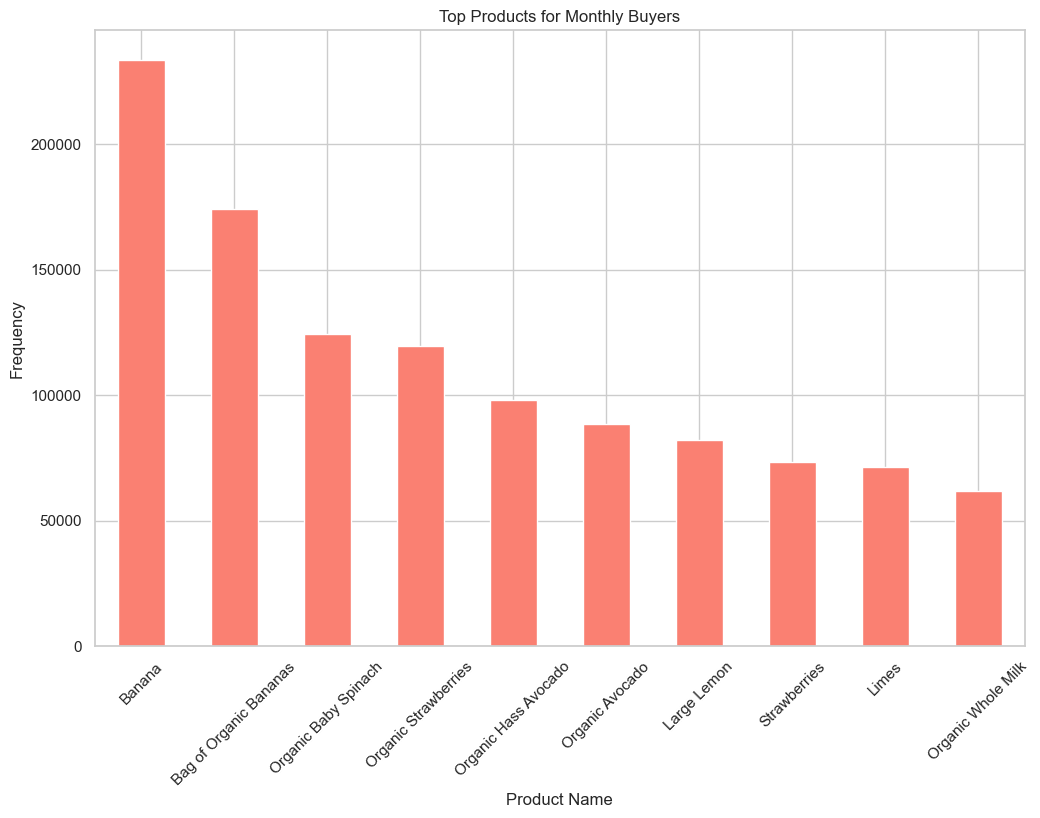

In [32]:
# Question 2: Top Products Purchased by Weekly and Monthly Buyers
# Weekly buyers - assumed to have orders with days_since_prior_order <= 7
# Monthly buyers - assumed to have orders with days_since_prior_order > 7 and <= 30
weekly_buyers = final_dataset[final_dataset['days_since_prior_order'] <= 7]
monthly_buyers = final_dataset[(final_dataset['days_since_prior_order'] > 7) & (final_dataset['days_since_prior_order'] <= 30)]

# Get top 10 products for each group
top_weekly_products = weekly_buyers['product_name'].value_counts().head(10)
top_monthly_products = monthly_buyers['product_name'].value_counts().head(10)

plt.figure(figsize=(12, 8))
top_weekly_products.plot(kind='bar', color='skyblue')
plt.title('Top Products for Weekly Buyers')
plt.xlabel('Product Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
top_monthly_products.plot(kind='bar', color='salmon')
plt.title('Top Products for Monthly Buyers')
plt.xlabel('Product Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### 2.4.4 - Hourly Sales Heatmap: Show how sales vary by the hour of the day.

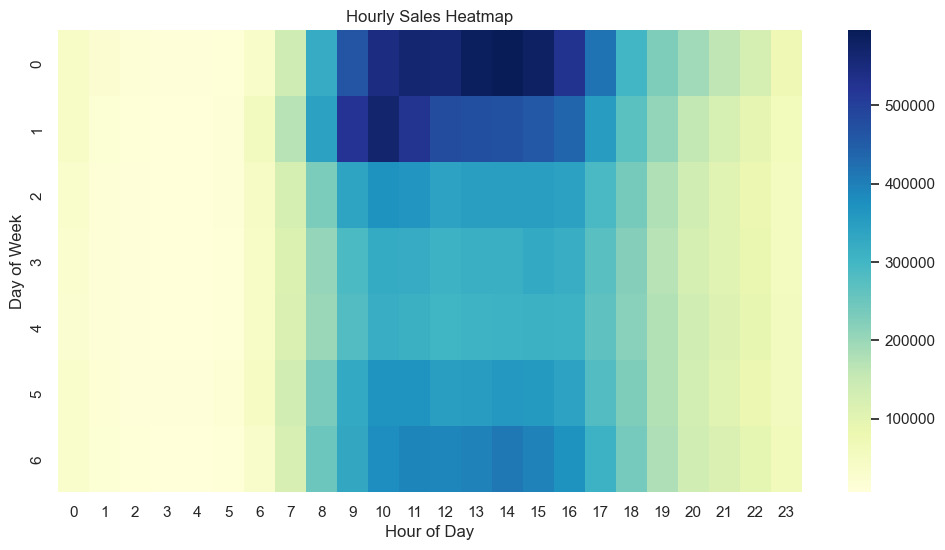

In [35]:
# Hourly Sales Heatmap
hourly_sales = final_dataset.groupby(['order_dow', 'order_hour_of_day']).size().reset_index(name='count')
hourly_sales_pivot = hourly_sales.pivot(index='order_dow', columns='order_hour_of_day', values='count')

plt.figure(figsize=(12, 6))
sns.heatmap(hourly_sales_pivot, cmap='YlGnBu')
plt.title('Hourly Sales Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

#### 2.4.5: Product Popularity by Time of Day: Identify which products are more popular at different times of the day.



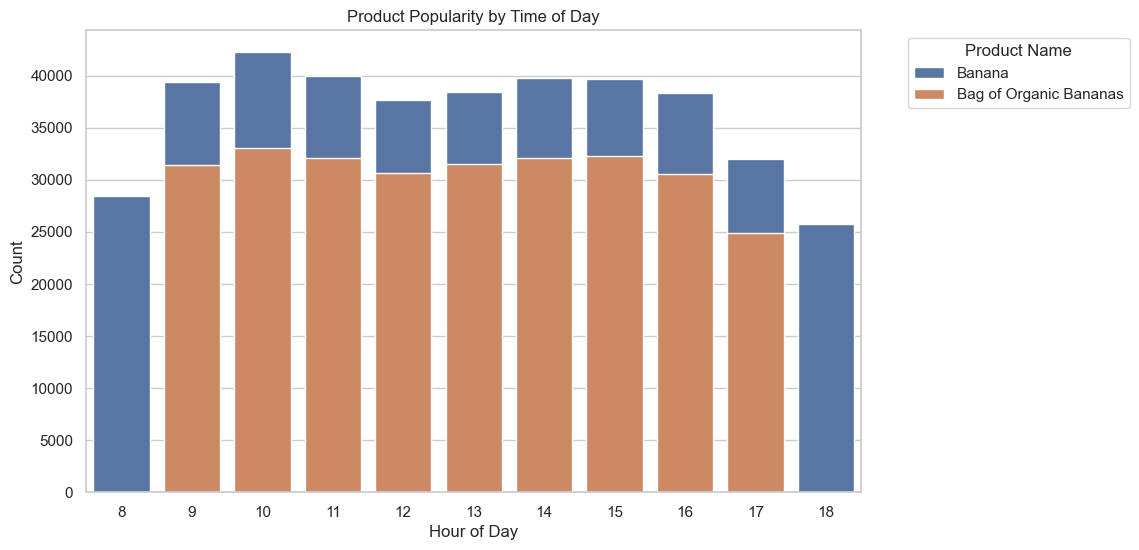

In [36]:
product_time_popularity = final_dataset.groupby(['product_name', 'order_hour_of_day']).size().reset_index(name='count')
top_products = product_time_popularity.sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='order_hour_of_day', y='count', hue='product_name', data=top_products, dodge=False)
plt.title('Product Popularity by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(title='Product Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


#### 2.4.6: Department-Wise Sales by Hour: This can help identify which departments are popular at what times of the day.

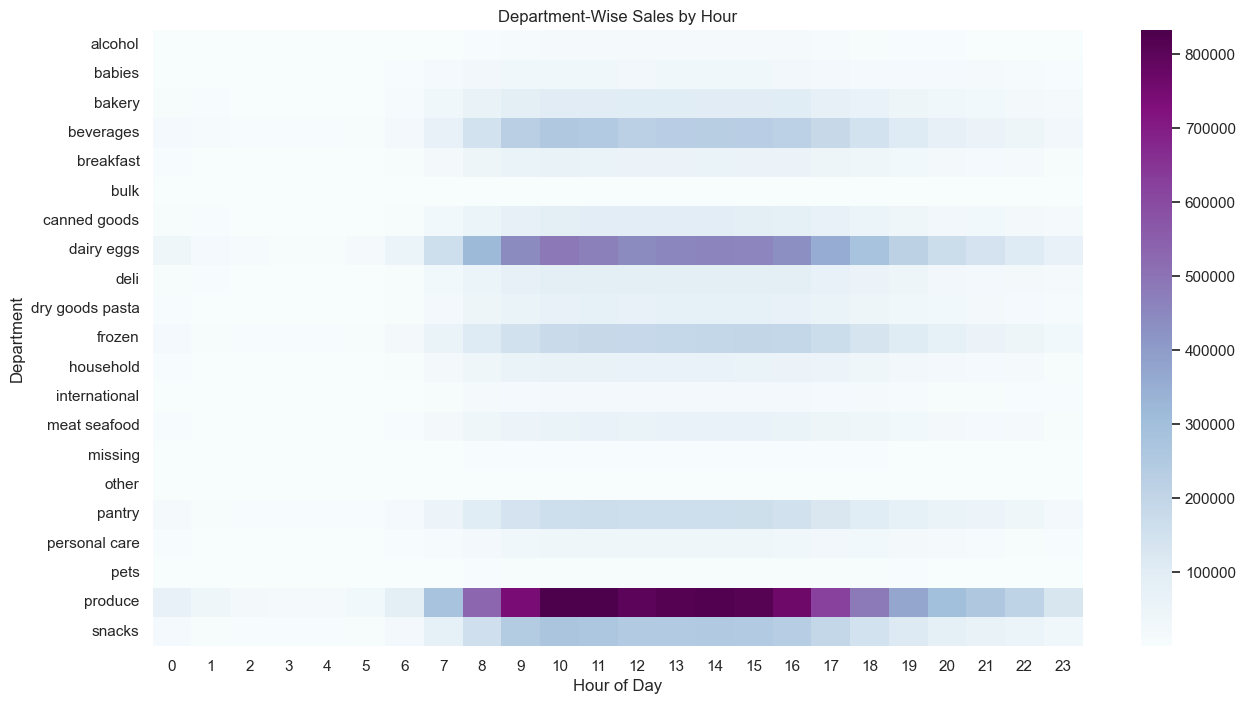

In [37]:
# Department-Wise Sales by Hour
department_hourly_sales = final_dataset.groupby(['department', 'order_hour_of_day']).size().reset_index(name='count')
# Correcting the pivot function syntax
department_hourly_sales_pivot = department_hourly_sales.pivot(index='department', columns='order_hour_of_day', values='count')

plt.figure(figsize=(15, 8))
sns.heatmap(department_hourly_sales_pivot, cmap='BuPu')
plt.title('Department-Wise Sales by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Department')
plt.show()

### 2.5 Position of Cart

- Reorder rate by add_to_cart_order: This will tell us if products added earlier in the cart tend to have a higher reorder rate.
- Frequency of being first in cart: We can count how often products are the first item in the cart, which might indicate their importance or popularity.
- Average add_to_cart_order for reorders vs. first-time orders: Comparing the average position of products when they are reordered versus when they are ordered for the first time.

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chandrajason/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

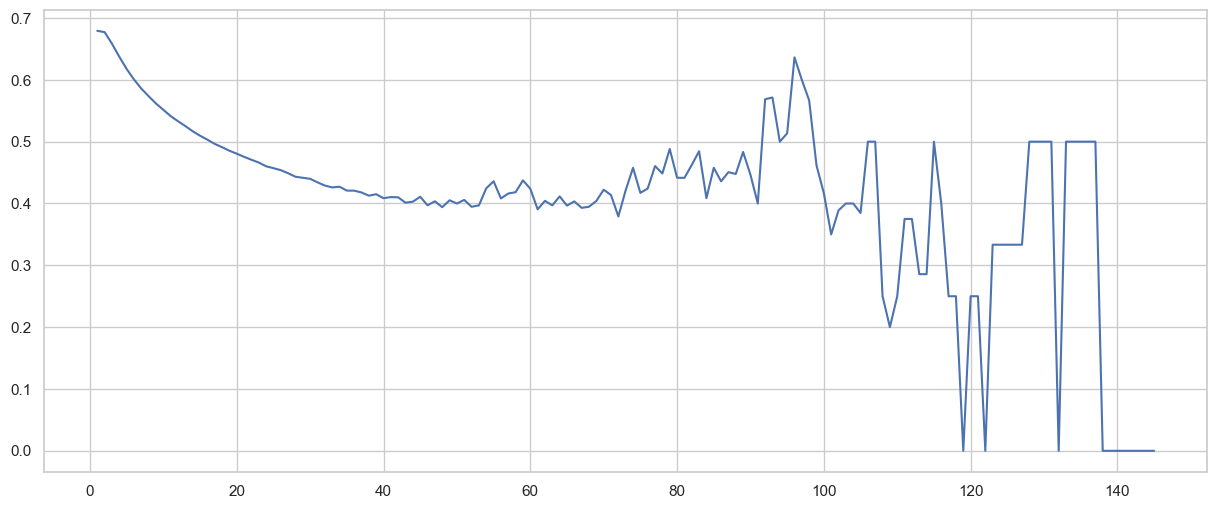

In [41]:
#### 2.5.1
# Converting 'reordered' to numeric if it's not already
final_dataset['reordered'] = pd.to_numeric(final_dataset['reordered'], errors='coerce')

# Converting 'add_to_cart_order' to numeric if it's not already
final_dataset['add_to_cart_order'] = pd.to_numeric(final_dataset['add_to_cart_order'], errors='coerce')

# Drop any rows that now have NaN in 'reordered' or 'add_to_cart_order'
final_dataset = final_dataset.dropna(subset=['reordered', 'add_to_cart_order'])

# Calculate reorder rate by cart position again
reorder_rate_by_position = final_dataset.groupby('add_to_cart_order')['reordered'].mean().reset_index()

# Plot reorder rate by cart position
plt.figure(figsize=(15, 6))
sns.lineplot(data=reorder_rate_by_position, x='add_to_cart_order', y='reordered')
plt.title('Reorder Rate by Position of Product in Cart')
plt.xlabel('Position in Cart')
plt.ylabel('Reorder Rate')
plt.show()


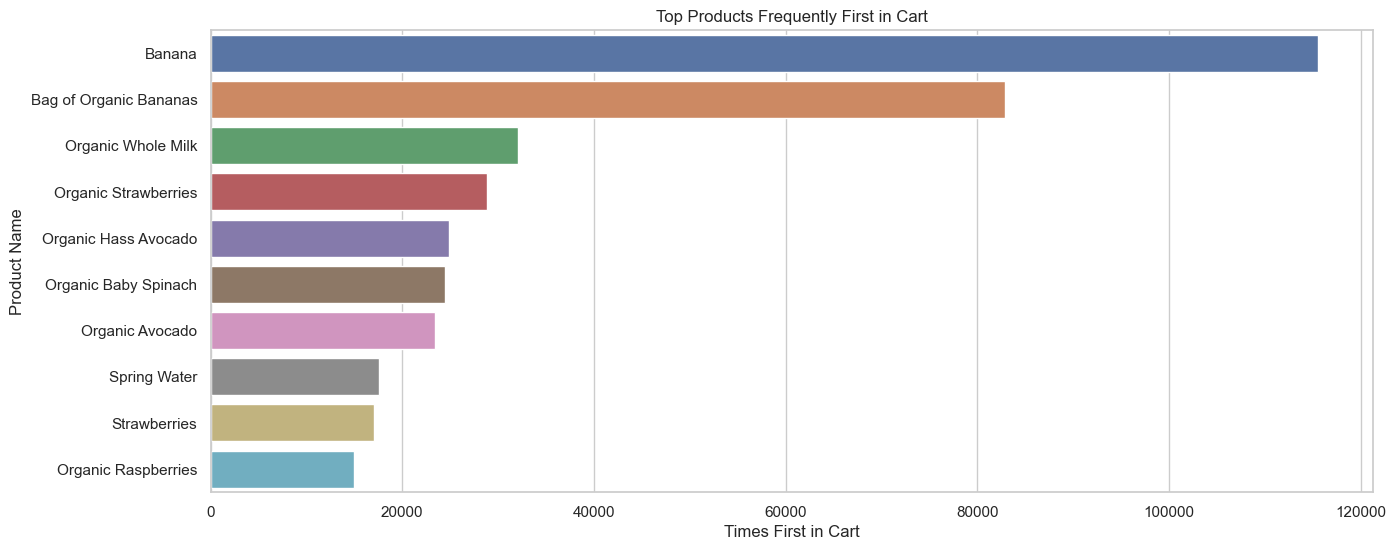

In [40]:
#### 2.5.2
# Calculate frequency of being first in cart
first_in_cart = final_dataset[final_dataset['add_to_cart_order'] == 1]['product_name'].value_counts().reset_index()
first_in_cart.columns = ['product_name', 'times_first_in_cart']

# Plot top products that are frequently first in cart
plt.figure(figsize=(15, 6))
sns.barplot(data=first_in_cart.head(10), x='times_first_in_cart', y='product_name')
plt.title('Top Products Frequently First in Cart')
plt.xlabel('Times First in Cart')
plt.ylabel('Product Name')
plt.show()


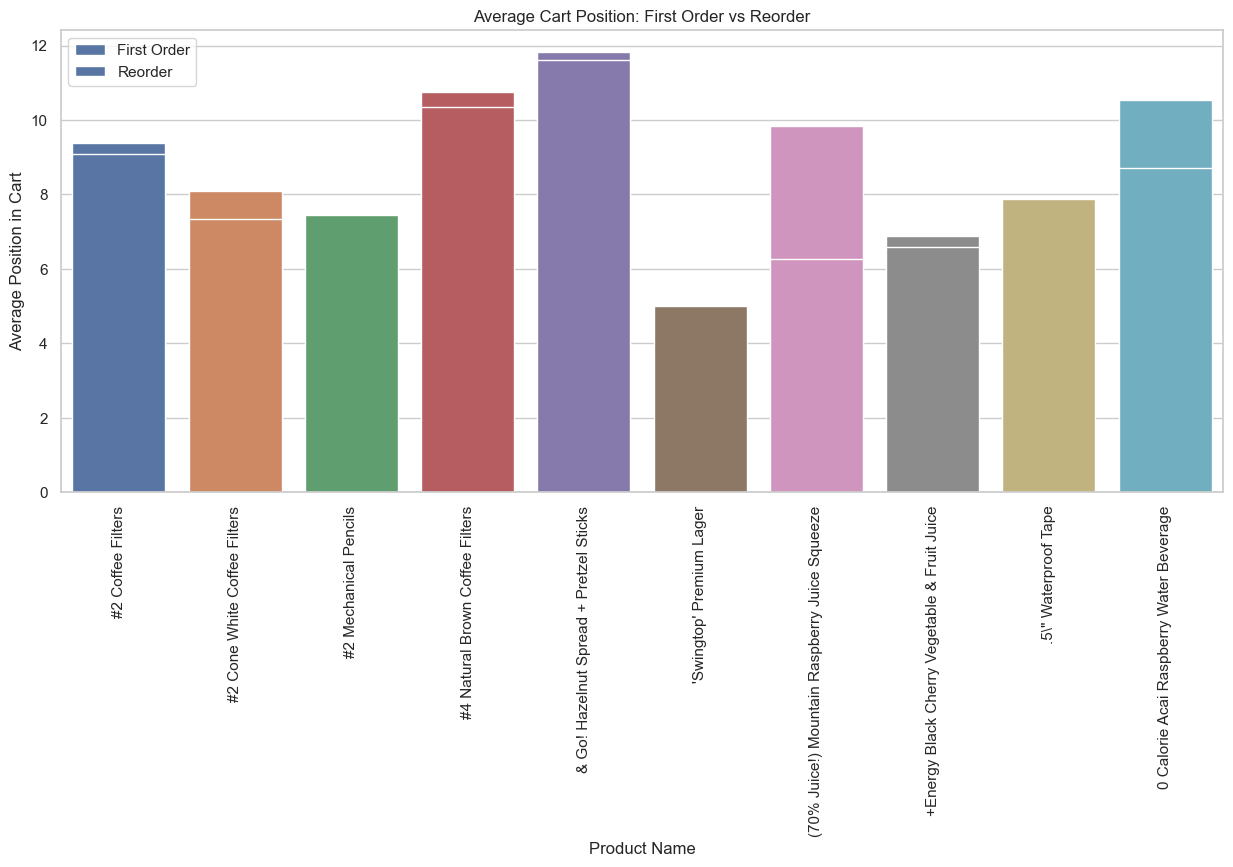

In [39]:
####2.5.3

# Calculate average position of reordered and first-time ordered products
average_position = final_dataset.groupby(['product_name', 'reordered'])['add_to_cart_order'].mean().unstack()
average_position.columns = ['average_position_first_order', 'average_position_reordered']
average_position = average_position.reset_index()

# Compare averages using a bar plot
plt.figure(figsize=(15, 6))
average_position = average_position.head(10) # limiting to top 10 products for visibility
sns.barplot(data=average_position, x='product_name', y='average_position_first_order', label='First Order')
sns.barplot(data=average_position, x='product_name', y='average_position_reordered', label='Reorder')
plt.title('Average Cart Position: First Order vs Reorder')
plt.xlabel('Product Name')
plt.xticks(rotation=90)
plt.ylabel('Average Position in Cart')
plt.legend()
plt.show()


### TO DISCUSS
- which plots are relevant
- which ones we can write blurbs/ summary on
- what other EDA is missing

Next steps; Feature engineer (NOT SURE BY HOW)